# Global Config Paramameters

In [1]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './pascal_voc_training_data.txt'
IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 7e-6
EPOCHS = 100

# import and download

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Configure GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,",
              len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPU


In [4]:
!nvidia-smi

Mon Nov 30 07:29:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3070    Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   47C    P2    45W / 220W |    275MiB /  7974MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
def classes_onehot(clsli):
    onehotli = [0] * 20
    for cls in clsli:
        onehotli[cls] += 1
    return onehotli 
training_data_file = open("./pascal_voc_training_data.txt", "r")
npoh = np.array([classes_onehot ([int(numstr) for numstr in line.strip().split(' ')[5::5]]) for i, line in enumerate(training_data_file)])

In [6]:
ww = (1 / (npoh[:, 14] + 2))
ww /= ww.min()
ww[np.argmin(ww)] = 2
ww /= ww.min()
ww = ww.round()
BALANCE_WEIGHTS = ww.astype('int').tolist()

In [7]:
nnpoh = np.tile(ww, (4974, 1)).dot(npoh)
nnpoh /= nnpoh.min()
(nnpoh.round().mean(), nnpoh.round().std())

(2.6, 2.2)

# Data Augmentation

Utilities to get transform matrix from transform dictionary.

In [8]:
from operator import itemgetter

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2
    o_y = float(y) / 2
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
#     print('offset:', offset_matrix)
#     print('transf:', matrix)
#     print('reset:', reset_matrix)
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def get_transform_matrix(transf):
    theta, tx, ty, shear, zx, zy = itemgetter(
        'theta', 'tx', 'ty', 'shear', 'zx', 'zy'
    )(transf)
    transform_matrix = None
    if theta != 0:
        theta = np.deg2rad(-theta)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                    [np.sin(theta), np.cos(theta), 0],
                                    [0, 0, 1]])
        transform_matrix = rotation_matrix

    if tx != 0 or ty != 0:
        shift_matrix = np.array([[1, 0, -tx],
                                 [0, 1, -ty],
                                 [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shift_matrix
        else:
            transform_matrix = np.dot(transform_matrix, shift_matrix)

    if shear != 0:
        shear = np.deg2rad(shear)
        shear_matrix = np.array([[1, -np.sin(shear), 0],
                                 [0, np.cos(shear), 0],
                                 [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shear_matrix
        else:
            transform_matrix = np.dot(transform_matrix, shear_matrix)

    if zx != 1 or zy != 1:
        zoom_matrix = np.array([[1 / (zx + 1e-7), 0, 0],
                                [0, 1 / (zy + 1e-7), 0],
                                [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = zoom_matrix
        else:
            transform_matrix = np.dot(transform_matrix, zoom_matrix)
    return transform_matrix

Define the augmentation function and its wrapper.

In [9]:
def augment(image, xct, yct, box_w, box_h, class_num):
    """
    Randomly transform an image of size (448, 448) into augmented image,
    and transform the bounding boxes of objects accordingly.
    
    Input range: [0, 1]
    Output range: [0, 255]
    """
    idg = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=5,
        brightness_range=(0.75, 1.25),
        zoom_range=(0.8, 1.2),
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='constant',
        cval=0.5,
    )
    transf = idg.get_random_transform(image.shape)
#     print(transf)
    transf_mat = get_transform_matrix(transf)
    transf_mat = transform_matrix_offset_center(transf_mat, 448, 448)
#     print(transf_mat)
    transf_mat[:, [0, 1]] = transf_mat[:, [1, 0]]
    transf_mat[[0, 1]] = transf_mat[[1, 0]]
#     print(transf_mat)

    new_xcs = np.zeros(xct.shape)
    new_ycs = np.zeros(yct.shape)
    new_box_ws = np.zeros(box_w.shape)
    new_box_hs = np.zeros(box_h.shape)

    for i in range(0, 20):
        if xct[i] == 0 and yct[i] == 0 and box_w[i] == 0 and box_h[i] == 0:
            break

        # Half widths
        sx = box_w[i] / 2
        sy = box_h[i] / 2

#         print(f'Before: ({xct[i]}, {yct[i]}) ({box_w[i], box_h[i]})')
    
        xa, ya, _ = transf_mat.dot(np.array([[xct[i] - sx, yct[i] - sy, 1.]]).T)
        xb, yb, _ = transf_mat.dot(np.array([[xct[i] - sx, yct[i] + sy, 1.]]).T)
        xc, yc, _ = transf_mat.dot(np.array([[xct[i] + sx, yct[i] - sy, 1.]]).T)
        xd, yd, _ = transf_mat.dot(np.array([[xct[i] + sx, yct[i] + sy, 1.]]).T)
        xs = np.hstack([xa, xb, xc, xd])
        ys = np.hstack([ya, yb, yc, yd])

        xl = np.clip(np.min(xs), 0., 448.)
        xr = np.clip(np.max(xs), 0., 448.)
        yl = np.clip(np.min(ys), 0., 448.)
        yr = np.clip(np.max(ys), 0., 448.)
    
        new_box_w = np.clip(xr - xl, 0., 448.)
        new_box_h = np.clip(yr - yl, 0., 448.)

        new_xc = (xl + xr) / 2
        new_yc = (yl + yr) / 2

        if transf['flip_horizontal'] == 1:
#             print('flipping from', new_xc)
            new_xc = 448. - new_xc
        
        new_xcs[i] = new_xc
        new_ycs[i] = new_yc
        new_box_ws[i] = new_box_w
        new_box_hs[i] = new_box_h

#         print(f'After: ({new_xcs[i]}, {new_ycs[i]}) ({new_box_ws[i]}, {new_box_hs[i]})')

    image = idg.apply_transform(image, transf)
    return (
        image.astype(np.float32),
        new_xcs.astype(np.float32), new_ycs.astype(np.float32),
        new_box_ws.astype(np.float32), new_box_hs.astype(np.float32)
    )

def py_augment(image, xcenter, ycenter, box_w, box_h, class_num):
    return tf.numpy_function(
        augment, [image, xcenter, ycenter, box_w, box_h, class_num],
        [tf.float32, tf.float32, tf.float32, tf.float32, tf.float32]
    )

Define the dataset generator

In [10]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self, is_vgg16=True):
        self.balw = tf.constant(BALANCE_WEIGHTS)
        self.is_vgg16 = is_vgg16
        self.image_indexes = []
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        last_index = 0
        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])
            self.image_indexes.append(last_index)
            last_index += 1

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # Map from [0, 256) to [0, 1)
        image = image / 255

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio
        
        ### Augmentation
        # Transform the image and boxes
        # Range is now [0, 255]
        image, xcenter, ycenter, box_w, box_h = py_augment(
            tf.cast(image, tf.float32),
            tf.cast(xcenter, tf.float32),
            tf.cast(ycenter, tf.float32),
            tf.cast(box_w, tf.float32),
            tf.cast(box_h, tf.float32),
            tf.cast(class_num, tf.float32)
        )
        # Preprocess into VGG16 format
        # Range is now unknown (?)
        if self.is_vgg16:
            image = tf.keras.applications.vgg16.preprocess_input(image)
        ################

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)
    
    def generate(self, debug=0):
        s = 0
        t = 10
        dataset = tf.data.Dataset.from_tensor_slices((self.image_indexes[s:t],
                                                      self.image_names[s:t], 
                                                      np.array(self.record_list[s:t]), 
                                                      np.array(self.object_num_list[s:t])))

        # Used only in non-debug mode.
        #  - Repeating some images
        #  - Shuffling
        if debug == 0:
            dataset = dataset.flat_map(
                lambda idx, name, lbl, objnum: tf.data.Dataset.from_tensors((name, lbl, objnum)).repeat(
                    tf.cast(self.balw[idx], tf.int64))
            )
            dataset = dataset.shuffle(100000)
        # Used only in debug mode.
        #  - Filter data w/ idx NOT in debug_gen_rng
        #  - Remove the "idx" column, to match non-debug branch behavior
        else:
            dataset = dataset.map(
                lambda idx, name, lbl, objnum: (name, lbl, objnum),
                num_parallel_calls = tf.data.experimental.AUTOTUNE
            )

        # Preprocessing for debug & non-debug mode are exactly the same
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)

        # Used only in non-debug mode.
        #  - Batching
        #  - Prefetching
        if debug == 0:
            dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
            dataset = dataset.prefetch(buffer_size=110)

        return dataset

Ensure that data augmentation is working

框框: 218.0 213.0 266.0 351.0
框框: 141.5 269.5 210.5 386.5
框框: 17.5 247.0 66.5 387.0
框框: 201.5 194.5 244.5 307.5
框框: 230.5 187.0 257.5 223.0
MIN/MAX/MEAN: 0.0 1.0 0.3822717


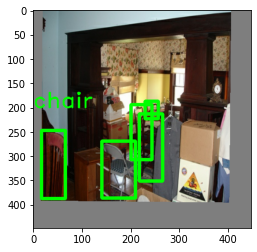

框框: 64.0 103.0 346.0 447.0
MIN/MAX/MEAN: 0.0 1.0 0.3613213


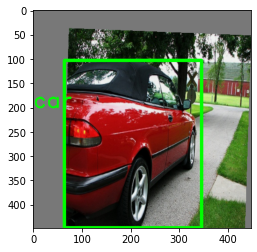

框框: 179.0 162.0 349.0 362.0
框框: 207.0 130.0 281.0 304.0
框框: 137.0 209.5 181.0 366.5
框框: 160.0 204.0 202.0 362.0
MIN/MAX/MEAN: 0.0 1.0 0.30098376


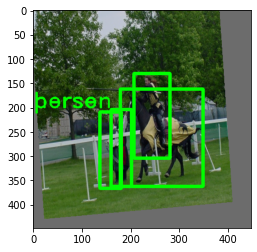

框框: 84.0 68.5 286.0 357.5
MIN/MAX/MEAN: 0.0 1.0 0.42951798


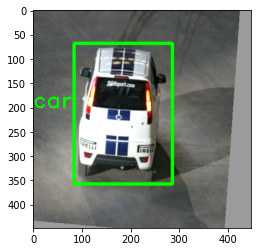

框框: 12.5 27.0 293.5 447.0
MIN/MAX/MEAN: 0.0 1.0 0.4152082


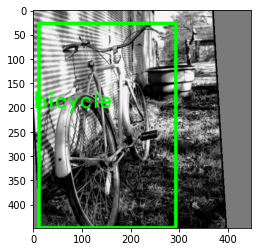

框框: 217.0 5.0 329.0 211.0
框框: 70.5 24.5 435.5 417.5
MIN/MAX/MEAN: 0.0 1.0 0.5495485


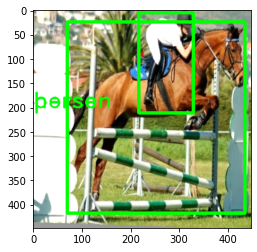

框框: 241.0 83.0 439.0 287.0
框框: 73.0 107.0 273.0 285.0
MIN/MAX/MEAN: 0.0 1.0 0.5419274


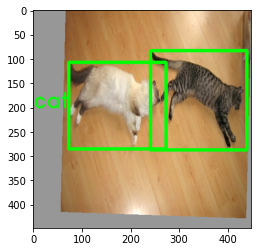

框框: 0.0 95.5 448.0 394.5
MIN/MAX/MEAN: 0.0 1.0 0.23638146


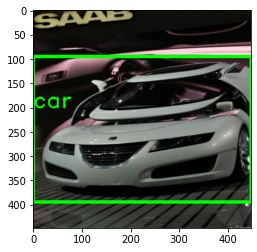

框框: 209.0 245.5 427.0 422.5
框框: 25.5 20.5 196.5 447.5
框框: 224.5 80.0 383.5 394.0
框框: 253.5 189.0 418.5 447.0
MIN/MAX/MEAN: 0.0 1.0 0.31227282


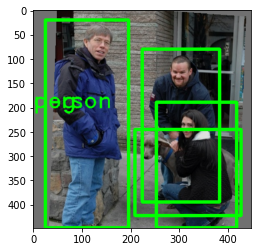

框框: 131.0 231.0 447.0 447.0
框框: 15.5 247.0 170.5 447.0
框框: 327.0 185.0 447.0 447.0
框框: 279.0 30.5 447.0 365.5
框框: 116.5 31.0 447.5 447.0
框框: 0.0 55.0 176.0 447.0
MIN/MAX/MEAN: 0.0 1.0 0.3487211


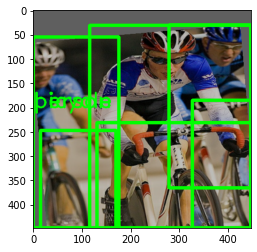

In [11]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

def annotate_img_rect(img, lbls, num):
    for i in range(0, 20):
        xc, yc, w, h, class_num = lbls[i, :]
        xmin, ymin, xmax, ymax = xc - w / 2, yc - h / 2, xc + w / 2, yc + h / 2
        
        if xmin == 0 and ymin == 0 and xmax == 0 and ymax == 0:
            return img, True
        
        print('框框:', xmin, ymin, xmax, ymax)
        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 5)
        cv2.putText(
            img, classes_name[class_num],
            (0, 200), 2, 1.5, (0, 255, 0), 2
        )
    return img, False

def test_augmentation():
    dg = DatasetGenerator(is_vgg16=False)
    i = 0
    for img, lbls, num in dg.generate(debug=True):
        if i > 20:
            break
        i += 1
        img = np.clip(np.array(img / 255.), 0., 1.)
        img, should_stop = annotate_img_rect(img, lbls.numpy().astype('int'), num.numpy())
        img = np.clip(img, 0., 1.)
        print('MIN/MAX/MEAN:', img.min(), img.max(), img.mean())
        plt.imshow(img)
        plt.show()
        if should_stop == True:
            continue

test_augmentation()

In [12]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

def debug_kuang_kuang(img, lbls, num):
    is_in_range = lambda x: x <= 448. and x >= 0
    for i in range(0, 20):
        xc, yc, w, h, class_num = lbls[i, :]
        xmin, ymin, xmax, ymax = xc - w / 2, yc - h / 2, xc + w / 2, yc + h / 2
        
        if (not is_in_range(xmin)) or (not is_in_range(ymin)) or (not is_in_range(xmax)) or (not is_in_range(ymax)):
            print('OOR:', xmin, ymin, xmax, ymax)
    

def test_debug_kuang_kuang():
    dg = DatasetGenerator(is_vgg16=False)
    i = 0
    for img, lbls, num in dg.generate(debug=True):
        debug_kuang_kuang(img, lbls, num)

# test_debug_kuang_kuang()

Define the model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x


# TODO : use pretrain model train on Imagenet for first 20 layers (?)
img_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img_shape)
vgg16.trainable = False

img_inputs = keras.Input(shape= img_shape)
x = vgg16(img_inputs)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, 
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, 
                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

YOLO.summary()

Model: "YOLO"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 14, 14, 512)       14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 1024)      4719616   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 1024)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 1024)        9438208   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 1024)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 1024)        9438208

In [14]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def clip_label(label):
    xct = label[0]
    yct = label[1]
    hw = label[2] / 2
    hh = label[3] / 2
    xmin = tf.clip_by_value(xct - hw, 1., 447.)
    xmax = tf.clip_by_value(xct + hw, 1., 447.)
    ymin = tf.clip_by_value(yct - hh, 1., 447.)
    ymax = tf.clip_by_value(yct + hh, 1., 447.)
    return tf.stack([(xmin + xmax) / 2, (ymin + ymax) / 2, xmax - xmin, ymax - ymin, label[4]])

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])
    label = clip_label(label)

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

dataset = DatasetGenerator().generate()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    LEARNING_RATE,
    decay_steps=50000,
    decay_rate=0.9,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO_VGG', max_to_keep=5,
                                     checkpoint_name='yolo')

Define the training step, and start training

In [ ]:
if manager.latest_checkpoint:
    ckpt.restore(manager.latest_checkpoint).assert_consumed()
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

from datetime import datetime

def log_train(logstr):
    print(logstr)
    trainlog = open('./trainlog.txt', 'a')
    trainlog.write(logstr + '\n')
    trainlog.close()

log_train("{}, start training.".format(datetime.now()))
for _ in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    log_train(f'Learning rate: {optimizer._decayed_lr("float32").numpy()}')
    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)
    
    log_train("{}, Epoch {}: loss {:.2f}".format(datetime.now(), int(ckpt.epoch), train_loss_metric.result()))

    save_path = manager.save()
    log_train("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

Initializing from scratch.
2020-11-30 07:29:25.181974, start training.
Learning rate: 7.000000096013537e-06
2020-11-30 07:29:50.678382, Epoch 1: loss 20562742.00
Saved checkpoint for epoch 1: ./ckpts/YOLO_VGG/yolo-1
Learning rate: 7.000000096013537e-06
2020-11-30 07:29:57.413728, Epoch 2: loss 9185965.00


# Predict and Evaluate

In [ ]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf


In [ ]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)


In [ ]:

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)
ckpt.restore(manager.latest_checkpoint)

@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()


Write the output file

In [ ]:
import sys
sys.path.insert(0, './evaluate')

import evaluate
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

# Visualization

In [ ]:
class VisDataGenerator:
    def __init__(self):
        self.record_list = []
        input_file = open(DATA_PATH, 'r')

        last_index = 0
        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])
            self.image_indexes.append(last_index)
            last_index += 1

            self.record_list.append([float(num) for num in ss[1:]])

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cv2

classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

# idx_to_show = 503
idx_to_show = 123

np_img = cv2.imread(f'./VOCdevkit_train/VOC2007/JPEGImages/{idx_to_show:06}.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

# Show prediction
y_pred = YOLO(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
print(xmin, ymin, xmax, ymax, class_name, conf)
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)
plt.imshow(resized_img)
plt.show()

np_img = cv2.imread(f'./VOCdevkit_train/VOC2007/JPEGImages/{idx_to_show:06}.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

# Show ground truth
true_data = {line.split(' ')[0] : np.array(
    list(map(lambda s: int(s), line.strip().split(' ')[1:]))
).reshape((-1, 5)).astype('int') for line in open(DATA_PATH, 'r')}
fname = f'{idx_to_show:06}.jpg'
for i in range(true_data[fname].shape[0]):
    xmin, ymin, xmax, ymax, class_num = true_data[fname][i, :]
    class_name = classes_name[class_num]
    print(xmin, ymin, xmax, ymax, class_name)
    cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 255, 0), 1)
    cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (255, 255, 0), 1)
plt.imshow(resized_img)
plt.show()